In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import pickle
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import lxml

### 00_All_Data_Jobs

With the initial analysis on filtering, I'm going to expand the data set from `Data+Scientist` to include more jobs in the same job family:
- Data+Scientist
- Data+Analyst
- Data+Engineer
- Machine+Learning

In [3]:
# link to the scrap 
# Data+Scientist, Data+Analyst, Data+Engineer, Machine+Learning

links = [
    'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=&year=All+Years',
    'https://h1bdata.info/index.php?em=&job=Data+Scientist+&city=&year=All+Years',
    'https://h1bdata.info/index.php?em=&job=Data+Analyst&city=&year=All+Years',
    'https://h1bdata.info/index.php?em=&job=Data+Analyst+&city=&year=All+Years',
    'https://h1bdata.info/index.php?em=&job=Data+Engineer&city=&year=All+Years',
    'https://h1bdata.info/index.php?em=&job=Data+Engineer+&city=&year=All+Years',
    'https://h1bdata.info/index.php?em=&job=Machine+Learning+&city=&year=All+Years'
]

jobs_list = []
for link in links:
    page_link = link
    page_response = requests.get(page_link, timeout=1000)
    page_content = BeautifulSoup(page_response.content, 'lxml')

    for row in page_content.find_all('tr')[1:]:
        row_data = []
        for i in row:
            row_data.append(i.text)
        jobs_list.append(row_data)

len(jobs_list)

28101

### 01_Create_Table

Store the list in a table for analysis.

In [4]:
# Put everything into dataframes for easier processing

ds_jobs_df = pd.DataFrame()
ds_jobs_df['company'] = [i[0] for i in jobs_list]
ds_jobs_df['title'] = [i[1] for i in jobs_list]
ds_jobs_df['salary'] = [i[2].replace(',','') for i in jobs_list]
ds_jobs_df['salary'] = ds_jobs_df['salary'].astype(float)
ds_jobs_df['location'] = [i[3] for i in jobs_list]
ds_jobs_df['date'] = [i[4] for i in jobs_list]
ds_jobs_df['date'] = pd.to_datetime(ds_jobs_df['date'])
ds_jobs_df['year'] = [i.year for i in ds_jobs_df['date']]

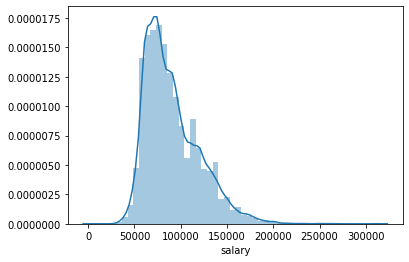

In [9]:
# initial view on new distribution

sns.distplot(ds_jobs_df[ds_jobs_df['salary']<400000]['salary'])

### 02_Outliners

Take a look at top and bottom of the dataframe.

In [10]:
ds_jobs_df.sort_values(by=["salary"], ascending=False).head(10)

,company,title,salary,location,date,year
7343,AIRBNB INC,DATA SCIENTIST,1350001.0,"SAN FRANCISCO, CA",2015-02-12,2015
20699,ANTRA INC,DATA ANALYST,847000.0,"WASHINGTON, DC",2019-05-07,2019
13956,ANTRA INC,DATA ANALYST,847000.0,"WASHINGTON, DC",2019-05-07,2019
170,LARSON LIVING LABS LLC,DATA SCIENTIST,312000.0,"CAMBRIDGE, MA",2018-03-21,2018
171,LARSON LIVING LABS LLC,DATA SCIENTIST,312000.0,"CAMBRIDGE, MA",2018-05-14,2018
27112,FACEBOOK INC,MACHINE LEARNING ACCELERATOR IMPLEMENTATION TE...,270000.0,"MENLO PARK, CA",2019-03-22,2019
25974,PRO US-CW,DATA ENGINEER,265200.0,"MENLO PARK, CA",2019-08-07,2019
7341,STITCH FIX INC,DATA SCIENTIST,260000.0,"SAN FRANCISCO, CA",2019-04-09,2019
7340,STITCH FIX INC,DATA SCIENTIST,260000.0,"SAN FRANCISCO, CA",2018-12-10,2018
7342,STITCH FIX INC,DATA SCIENTIST,260000.0,"SAN FRANCISCO, CA",2019-05-24,2019


In [11]:
ds_jobs_df.sort_values(by=["salary"], ascending=True).head(10)

,company,title,salary,location,date,year
172,THREATMETRIX INC,DATA SCIENTIST,5769.0,"SAN JOSE, CA",2015-01-06,2015
173,DOMINION ENTERPRISES,DATA SCIENTIST,29973.0,"NORFOLK, VA",2016-03-01,2016
13974,SUMMIT ENERGY SERVICES INC,DATA ANALYSIS ASSOCIATE,31574.0,"LOUISVILLE, KY",2015-03-20,2015
7344,NYC METRO REGIONAL CENTER LLC,DATA ANALYST,33380.0,"FLUSHING, NY",2016-03-24,2016
14087,NYC METRO REGIONAL CENTER LLC,DATA ANALYST,33380.0,"FLUSHING, NY",2016-03-24,2016
7923,INSTITUTE FOR TRUTH IN ACCOUNTING,DATA ANALYST,34050.0,"CHICAGO, IL",2017-03-22,2017
7924,INSTITUTE FOR TRUTH IN ACCOUNTING,DATA ANALYST,34050.0,"CHICAGO, IL",2017-03-22,2017
14667,INSTITUTE FOR TRUTH IN ACCOUNTING,DATA ANALYST,34050.0,"CHICAGO, IL",2017-03-22,2017
7925,INSTITUTE FOR TRUTH IN ACCOUNTING,DATA ANALYST,34050.0,"CHICAGO, IL",2017-03-22,2017
7926,INSTITUTE FOR TRUTH IN ACCOUNTING,DATA ANALYST,34050.0,"CHICAGO, IL",2017-03-22,2017


In [12]:
# data_by_year
ds_jobs_df[["year","title"]].groupby(["year"]).count()

,title
year,
2012,5
2013,13
2014,294
2015,2721
2016,4999
2017,5212
2018,7022
2019,7835


Looks like the exclusion criteria we came up from previous analysis is still relevant.

In [5]:
# Excluding Outliners

# Drop pre 2014 data (very few observations pre 2014)
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['year']<=2014].index, axis=0, inplace=True)

# Drop salaries over $400,000
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['salary']>400000].index, axis=0, inplace=True)

# Drop salaries lower than $200,000
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['salary']<20000].index, axis=0, inplace=True)

# Sort by company and year
ds_jobs_df.sort_values(by=['year','company'], inplace=True, ascending=True)

In [6]:
ds_jobs_df.shape # population drops from 28,101 to 27,785 after exclusion

(27785, 6)

### 03_Job_Families

This time I included all the job titles containing the key words. To get some meaningful analysis I need to group them in a meaningful way to distinguish the different job titles I use for analysis.

In [32]:
ds_jobs_df[["title","salary"]].groupby(["title"]).size().nlargest(15).reset_index(name='top15')

,title,top15
0,DATA ANALYST,13062
1,DATA SCIENTIST,7266
2,DATA ENGINEER,2894
3,DATA ANALYST 2,841
4,DATA ENGINEER II,577
5,MACHINE LEARNING ENGINEER,555
6,DATA ANALYST 3,317
7,DATA ENGINEER I,167
8,DATA ANALYST II,155
9,DATA ENGINEER III,120


Next, create a new column to group these job families into 5 categories:
- Data Scientist
- Data Analyst
- Data Engineer
- MACHINE LEARNING ENGINEER
- Manager 

In [67]:
def title_category (row):
    if 'MANAGER' in row['title']:
        return 'MANAGER'
    elif 'DATA SCIENTIST' in row['title']:
        return 'DATA SCIENTIST'
    elif ('DATA ANALYST' in row['title'] or 'DATA ANALYSIS' in row['title']):
        return 'DATA ANALYST'
    elif 'DATA ENGINEER' in row['title']:
        return 'DATA ENGINEER'
    elif 'MACHINE LEARNING' in row['title']:
        return 'MACHINE LEARNING'  
    else:
        return 'OTHERS'

In [68]:
ds_jobs_df['title_category'] = ds_jobs_df.apply(lambda row: title_category(row), axis=1)

In [71]:
ds_jobs_df[["title","title_category"]].groupby(["title_category"]).size().nlargest(10).reset_index(name='category')

,title_category,top
0,DATA ANALYST,15422
1,DATA SCIENTIST,7326
2,DATA ENGINEER,3992
3,MACHINE LEARNING,964
4,MANAGER,80
5,OTHERS,1


In [73]:
# With above logic, the only uncategorized data is a type 
ds_jobs_df[ds_jobs_df["title_category"]=='OTHERS'].head()

,company,title,salary,location,date,year,title_category
14086,LYFT INC,DATA ANALYSST,140000.0,"SAN FRANCISCO, CA",2018-03-01,2018,OTHERS


In [83]:
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['title_category'] == 'OTHERS'].index, axis=0, inplace=True)
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['title_category'] == 'MANAGER'].index, axis=0, inplace=True)

In [84]:
ds_jobs_df[["title","title_category"]].groupby(["title_category"]).size().nlargest(10).reset_index(name='category')

,title_category,category
0,DATA ANALYST,15422
1,DATA SCIENTIST,7326
2,DATA ENGINEER,3992
3,MACHINE LEARNING,964


### 04_Job_Families_Comparison

Now the fun part begins! Let's take a look at the year to year for different job families.

In [90]:
# data_by_year_trending
ds_jobs_df[["year","title_category","title"]].groupby(["year","title_category"]).count()

title
year title_category         
2015 DATA ANALYST       1861
     DATA ENGINEER       245
     DATA SCIENTIST      562
     MACHINE LEARNING     43
2016 DATA ANALYST       3629
     DATA ENGINEER       407
     DATA SCIENTIST      910
     MACHINE LEARNING     44
2017 DATA ANALYST       3096
     DATA ENGINEER       671
     DATA SCIENTIST     1290
     MACHINE LEARNING    133
2018 DATA ANALYST       3391
     DATA ENGINEER      1146
     DATA SCIENTIST     2186
     MACHINE LEARNING    276
2019 DATA ANALYST       3445
     DATA ENGINEER      1523
     DATA SCIENTIST     2378
     MACHINE LEARNING    468

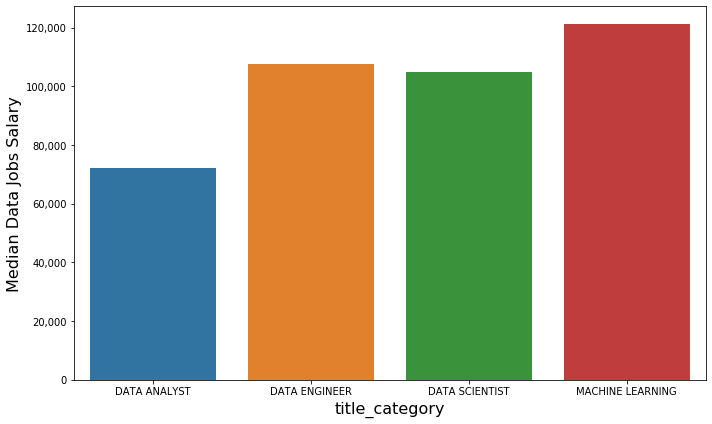

In [86]:
# median salary

median_salary = ds_jobs_df.groupby(by=['title_category']).median().reset_index()

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=median_salary['title_category'], 
                 y=median_salary['salary'])
ax.set_xlabel("title_category",fontsize=16)
ax.set_ylabel("Median Data Jobs Salary",fontsize=16)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.savefig(fname='median_salary', dpi=150)

In [89]:
median_salary = ds_jobs_df.groupby(by=['title_category']).median().reset_index()
median_salary[['title_category','salary']].sort_values(['salary'])

,title_category,salary
0,DATA ANALYST,72176.0
2,DATA SCIENTIST,105000.0
1,DATA ENGINEER,107468.0
3,MACHINE LEARNING,121191.5


Unsurprisingly, DA is lowest pay among data job family and Machine Learning Engineer/Scientist have the high salary. The interesting finding is that DE and DS have very close median salary with DE slightly higher. 